In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/7791.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/8401.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5761.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/8451.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5511.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/2721.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/2921.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/371.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5671.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/5421.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/4061.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/4751.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/1891.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blueband/rust/7851.TIF
/kaggle/input/new-coffee-11/coffee_augmented/blue

In [17]:
#!pip install imagecodecs

In [18]:
!pip install tensorflow tifffile opencv-python
import tifffile as tiff

In [19]:
import os
import numpy as np
import cv2
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
RGB_FOLDER = "rgb"  # ✅ Folder name for RGB images

def load_rgb_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, RGB_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        # Assuming RGB images are JPG/PNG
        files = [f for f in os.listdir(band_path) if f.lower().endswith((".jpg", ".png"))]
        print(f"\n{label.upper()} — Found {len(files)} RGB images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)

                # Load RGB image
                img = cv2.imread(img_path, cv2.IMREAD_COLOR)

                if img is None:
                    print(f"[ERROR] Could not read {f}, skipping...")
                    continue

                # Convert BGR (OpenCV default) to RGB
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Resize
                img = cv2.resize(img, IMAGE_SIZE)

                # Normalize to float32
                img = img.astype(np.float32)

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} RGB images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_rgb, y_rgb = load_rgb_dataset()
print("✅ Final dataset shape:", X_rgb.shape, y_rgb.shape)  # Expecting: (num_images, 224, 224, 3), (num_images,)


NORUST — Found 819 RGB images


Loading norust: 100%|██████████| 819/819 [00:02<00:00, 316.30it/s]



RUST — Found 848 RGB images


Loading rust: 100%|██████████| 848/848 [00:02<00:00, 307.79it/s]



✅ Finished loading: 1667 RGB images total.
✅ Final dataset shape: (1667, 224, 224, 3) (1667,)


In [20]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image before NDVI computation
SELECTED_BANDS = [3, 5]  # Red, NIR

BAND_FOLDERS = {
    0: "rgb",
    1: "blueband",
    2: "greenband",
    3: "redband",
    4: "rededgeband",
    5: "nir"
}

def compute_ndvi_image(red, nir):
    # Compute NDVI = (NIR - Red) / (NIR + Red)
    ndvi = (nir - red) / (nir + red + 1e-6)
    ndvi = np.clip(ndvi, -1, 1)
    return ndvi.reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

def load_ndvi_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_files = {band_id: {} for band_id in SELECTED_BANDS}

        for band_id in SELECTED_BANDS:
            band_path = os.path.join(DATA_DIR, BAND_FOLDERS[band_id], label)
            if not os.path.exists(band_path):
                raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

            for f in os.listdir(band_path):
                ext = f.lower().split('.')[-1]
                if band_id == 0 and ext not in ["jpg", "jpeg", "png"]:
                    continue
                elif band_id != 0 and ext != "tif":
                    continue

                try:
                    base = int(f.split('.')[0])
                    band_files[band_id][base] = os.path.join(band_path, f)
                except:
                    print(f"[WARN] Skipping unreadable filename: {f}")

        # Match samples across bands
        common_bases = set(k - (k % 10) for k in band_files[SELECTED_BANDS[0]].keys())
        for band_id in SELECTED_BANDS[1:]:
            common_bases &= set(k - (k % 10) for k in band_files[band_id].keys())

        print(f"\n{label.upper()} — Found {len(common_bases)} complete sample sets")

        for base in tqdm(sorted(common_bases), desc=f"Loading {label}"):
            try:
                band_images = {}
                for band_id in SELECTED_BANDS:
                    file_id = base + band_id
                    file_path = band_files[band_id].get(file_id, None)
                    if file_path is None:
                        raise FileNotFoundError(f"[MISSING] {file_id} in band {BAND_FOLDERS[band_id]}")

                    img = tiff.imread(file_path)
                    img = cv2.resize(img, IMAGE_SIZE)
                    band_images[band_id] = img.astype(np.float32)

                red = band_images[3]
                nir = band_images[5]

                ndvi_img = compute_ndvi_image(red, nir)
                X.append(ndvi_img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping sample base {base}: {e}")

    print(f"\n✅ Finished loading: {len(X)} images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_ndvi, y_ndvi = load_ndvi_dataset()  # From your NDVI loader
print("✅ Final dataset shape:", X_ndvi.shape, y_ndvi.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 complete sample sets


Loading norust: 100%|██████████| 819/819 [00:03<00:00, 253.09it/s]



RUST — Found 848 complete sample sets


Loading rust: 100%|██████████| 848/848 [00:03<00:00, 239.17it/s]



✅ Finished loading: 1667 images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [21]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
NIR_BAND_FOLDER = "nir"  # ✅ Folder name for NIR band

def load_nir_band_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, NIR_BAND_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        files = [f for f in os.listdir(band_path) if f.lower().endswith(".tif")]
        print(f"\n{label.upper()} — Found {len(files)} NIR band images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)
                img = tiff.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                img = img.astype(np.float32).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} NIR band images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_nir, y_nir = load_nir_band_dataset()
print("✅ Final dataset shape:", X_nir.shape, y_nir.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 NIR band images


Loading norust: 100%|██████████| 819/819 [00:01<00:00, 459.90it/s]



RUST — Found 848 NIR band images


Loading rust: 100%|██████████| 848/848 [00:01<00:00, 440.69it/s]



✅ Finished loading: 1667 NIR band images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [22]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
REDEDGE_BAND_FOLDER = "rededgeband"  # ✅ Folder name for Red Edge band

def load_rededge_band_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, REDEDGE_BAND_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        files = [f for f in os.listdir(band_path) if f.lower().endswith(".tif")]
        print(f"\n{label.upper()} — Found {len(files)} Red Edge band images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)
                img = tiff.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                img = img.astype(np.float32).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} Red Edge band images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_rededge, y_rededge = load_rededge_band_dataset()
print("✅ Final dataset shape:", X_rededge.shape, y_rededge.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 Red Edge band images


Loading norust: 100%|██████████| 819/819 [00:02<00:00, 311.13it/s]



RUST — Found 848 Red Edge band images


Loading rust: 100%|██████████| 848/848 [00:02<00:00, 288.16it/s]



✅ Finished loading: 1667 Red Edge band images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [23]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
RED_BAND_ID = 3  # Red band
RED_BAND_FOLDER = "redband"  # Folder name for red band

def load_red_band_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, RED_BAND_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        files = [f for f in os.listdir(band_path) if f.lower().endswith(".tif")]
        print(f"\n{label.upper()} — Found {len(files)} red band images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)
                img = tiff.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                img = img.astype(np.float32).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} red band images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_red, y_red = load_red_band_dataset()  # From your red band loader
print("✅ Final dataset shape:", X_red.shape, y_red.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 red band images


Loading norust: 100%|██████████| 819/819 [00:01<00:00, 471.51it/s]



RUST — Found 848 red band images


Loading rust: 100%|██████████| 848/848 [00:01<00:00, 494.66it/s]



✅ Finished loading: 1667 red band images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [24]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
BLUE_BAND_ID = 1  # Example ID for Blue band
BLUE_BAND_FOLDER = "blueband"  # ✅ Updated folder name

def load_blue_band_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, BLUE_BAND_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        files = [f for f in os.listdir(band_path) if f.lower().endswith(".tif")]
        print(f"\n{label.upper()} — Found {len(files)} Blue band images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)
                img = tiff.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                img = img.astype(np.float32).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)  # Add channel dimension

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} Blue band images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Dataset ===
X_blue, y_blue = load_blue_band_dataset()  # From your Blue band loader
print("✅ Final dataset shape:", X_blue.shape, y_blue.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 Blue band images


Loading norust: 100%|██████████| 819/819 [00:02<00:00, 305.01it/s]



RUST — Found 848 Blue band images


Loading rust: 100%|██████████| 848/848 [00:02<00:00, 297.23it/s]



✅ Finished loading: 1667 Blue band images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [25]:
import os
import numpy as np
import cv2
import tifffile as tiff
from tqdm import tqdm

# ==== CONFIG ====
DATA_DIR = "/kaggle/input/new-coffee-11/coffee_augmented"
LABELS = ["norust", "rust"]
IMAGE_SIZE = (224, 224)  # Resize image
GREEN_BAND_ID = 2
GREEN_BAND_FOLDER = "greenband"  # Folder name for green band

def load_green_band_dataset():
    X, y = [], []

    for label_idx, label in enumerate(LABELS):
        band_path = os.path.join(DATA_DIR, GREEN_BAND_FOLDER, label)
        if not os.path.exists(band_path):
            raise FileNotFoundError(f"[ERROR] Folder not found: {band_path}")

        files = [f for f in os.listdir(band_path) if f.lower().endswith(".tif")]
        print(f"\n{label.upper()} — Found {len(files)} green band images")

        for f in tqdm(files, desc=f"Loading {label}"):
            try:
                img_path = os.path.join(band_path, f)
                img = tiff.imread(img_path)
                img = cv2.resize(img, IMAGE_SIZE)
                img = img.astype(np.float32).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

                X.append(img)
                y.append(label_idx)

            except Exception as e:
                print(f"[ERROR] Skipping file {f}: {e}")

    print(f"\n✅ Finished loading: {len(X)} green band images total.")
    return np.array(X, dtype=np.float32), np.array(y)

# === Load Green Band Dataset ===
X_green, y_green = load_green_band_dataset()
print("✅ Final dataset shape:", X_green.shape, y_green.shape)  # Expecting: (num_images, 224, 224, 1), (num_images,)


NORUST — Found 819 green band images


Loading norust: 100%|██████████| 819/819 [00:02<00:00, 323.27it/s]



RUST — Found 848 green band images


Loading rust: 100%|██████████| 848/848 [00:02<00:00, 311.35it/s]



✅ Finished loading: 1667 green band images total.
✅ Final dataset shape: (1667, 224, 224, 1) (1667,)


In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [27]:
# ✅ Check dataset lengths match across all 6 bands + NDRE
assert len(X_rgb) == len(X_red) == len(X_green) == len(X_blue) == \
       len(X_rededge) == len(X_nir) == len(X_ndvi) == \
       len(y_rgb) == len(y_red) == len(y_green) == len(y_blue) == \
       len(y_rededge) == len(y_nir) == len(y_ndvi), "Mismatch in dataset lengths"

# ✅ Check labels are identical across all datasets
assert np.array_equal(y_rgb, y_red) and \
       np.array_equal(y_rgb, y_green) and \
       np.array_equal(y_rgb, y_blue) and \
       np.array_equal(y_rgb, y_rededge) and \
       np.array_equal(y_rgb, y_nir) and \
       np.array_equal(y_rgb, y_ndvi), "Label mismatch among datasets"

In [28]:
y = y_rgb

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# === Normalize inputs ===
X_rgb = X_rgb / 255.0        # RGB in [0,1]
X_red = X_red / 255.0        # Red in [0,1]
X_green = X_green / 255.0    # Green in [0,1]
X_blue = X_blue / 255.0      # Blue in [0,1]
X_rededge = X_rededge / 255.0  # Red-edge in [0,1]
X_nir = X_nir / 255.0        # NIR in [0,1]
X_ndvi = X_ndvi / 1.0        # Already normalized (e.g., [-1,1])

# === Convert labels to categorical ===
y_cat = to_categorical(y, num_classes=2)

# === Step 1: Split into 80% train+val, 20% test ===
Xrgb_temp, Xrgb_test, \
Xred_temp, Xred_test, \
Xgreen_temp, Xgreen_test, \
Xblue_temp, Xblue_test, \
Xrededge_temp, Xrededge_test, \
Xnir_temp, Xnir_test, \
Xndvi_temp, Xndvi_test, \
y_temp, y_test = train_test_split(
    X_rgb, X_red, X_green, X_blue, X_rededge, X_nir, X_ndvi, y_cat,
    test_size=0.2, random_state=42, stratify=y
)

# === Step 2: Split 80% part into 70% train, 10% val ===
# (10 / 80 = 0.125 → 12.5% validation from train_val)
Xrgb_train, Xrgb_val, \
Xred_train, Xred_val, \
Xgreen_train, Xgreen_val, \
Xblue_train, Xblue_val, \
Xrededge_train, Xrededge_val, \
Xnir_train, Xnir_val, \
Xndvi_train, Xndvi_val, \
y_train, y_val = train_test_split(
    Xrgb_temp, Xred_temp, Xgreen_temp, Xblue_temp, Xrededge_temp, Xnir_temp, Xndvi_temp, y_temp,
    test_size=0.125, random_state=42, stratify=np.argmax(y_temp, axis=1)
)

In [31]:
print("🔴 RGB Band Shapes:")
print("Train:", Xrgb_train.shape)
print("Val:  ", Xrgb_val.shape)
print("Test: ", Xrgb_test.shape)

print("\n❤️ Red Band Shapes:")
print("Train:", Xred_train.shape)
print("Val:  ", Xred_val.shape)
print("Test: ", Xred_test.shape)

print("\n💚 Green Band Shapes:")
print("Train:", Xgreen_train.shape)
print("Val:  ", Xgreen_val.shape)
print("Test: ", Xgreen_test.shape)

print("\n💙 Blue Band Shapes:")
print("Train:", Xblue_train.shape)
print("Val:  ", Xblue_val.shape)
print("Test: ", Xblue_test.shape)

print("\n🌿 RedEdge Band Shapes:")
print("Train:", Xrededge_train.shape)
print("Val:  ", Xrededge_val.shape)
print("Test: ", Xrededge_test.shape)

print("\n🟢 NIR Band Shapes:")
print("Train:", Xnir_train.shape)
print("Val:  ", Xnir_val.shape)
print("Test: ", Xnir_test.shape)

print("\n🌱 NDVI Index Shapes:")
print("Train:", Xndvi_train.shape)
print("Val:  ", Xndvi_val.shape)
print("Test: ", Xndvi_test.shape)

print("\n🏷️ Label Shapes:")
print("Train:", y_train.shape)
print("Val:  ", y_val.shape)
print("Test: ", y_test.shape)


🔴 RGB Band Shapes:
Train: (1166, 224, 224, 3)
Val:   (167, 224, 224, 3)
Test:  (334, 224, 224, 3)

❤️ Red Band Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

💚 Green Band Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

💙 Blue Band Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🌿 RedEdge Band Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🟢 NIR Band Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🌱 NDVI Index Shapes:
Train: (1166, 224, 224, 1)
Val:   (167, 224, 224, 1)
Test:  (334, 224, 224, 1)

🏷️ Label Shapes:
Train: (1166, 2)
Val:   (167, 2)
Test:  (334, 2)


In [34]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model

# === RGB branch (3 channels) ===
input_rgb = Input(shape=(224, 224, 3), name="rgb_input")
x_rgb = Conv2D(32, (3, 3), activation='relu')(input_rgb)
x_rgb = MaxPooling2D((2, 2))(x_rgb)
x_rgb = Conv2D(64, (3, 3), activation='relu')(x_rgb)
x_rgb = MaxPooling2D((2, 2))(x_rgb)
x_rgb = Flatten()(x_rgb)
x_rgb = Dense(128, activation='relu')(x_rgb)
x_rgb = Dropout(0.5)(x_rgb)

# === Red branch ===
input_red = Input(shape=(224, 224, 1), name="red_input")
x_red = Conv2D(16, (3, 3), activation='relu')(input_red)
x_red = MaxPooling2D((2, 2))(x_red)
x_red = Conv2D(32, (3, 3), activation='relu')(x_red)
x_red = MaxPooling2D((2, 2))(x_red)
x_red = Flatten()(x_red)
x_red = Dense(128, activation='relu')(x_red)
x_red = Dropout(0.5)(x_red)

# === Green branch ===
input_green = Input(shape=(224, 224, 1), name="green_input")
x_green = Conv2D(16, (3, 3), activation='relu')(input_green)
x_green = MaxPooling2D((2, 2))(x_green)
x_green = Conv2D(32, (3, 3), activation='relu')(x_green)
x_green = MaxPooling2D((2, 2))(x_green)
x_green = Flatten()(x_green)
x_green = Dense(128, activation='relu')(x_green)
x_green = Dropout(0.5)(x_green)

# === Blue branch ===
input_blue = Input(shape=(224, 224, 1), name="blue_input")
x_blue = Conv2D(16, (3, 3), activation='relu')(input_blue)
x_blue = MaxPooling2D((2, 2))(x_blue)
x_blue = Conv2D(32, (3, 3), activation='relu')(x_blue)
x_blue = MaxPooling2D((2, 2))(x_blue)
x_blue = Flatten()(x_blue)
x_blue = Dense(128, activation='relu')(x_blue)
x_blue = Dropout(0.5)(x_blue)

# === RedEdge branch ===
input_rededge = Input(shape=(224, 224, 1), name="rededge_input")
x_rededge = Conv2D(16, (3, 3), activation='relu')(input_rededge)
x_rededge = MaxPooling2D((2, 2))(x_rededge)
x_rededge = Conv2D(32, (3, 3), activation='relu')(x_rededge)
x_rededge = MaxPooling2D((2, 2))(x_rededge)
x_rededge = Flatten()(x_rededge)
x_rededge = Dense(128, activation='relu')(x_rededge)
x_rededge = Dropout(0.5)(x_rededge)

# === NIR branch ===
input_nir = Input(shape=(224, 224, 1), name="nir_input")
x_nir = Conv2D(16, (3, 3), activation='relu')(input_nir)
x_nir = MaxPooling2D((2, 2))(x_nir)
x_nir = Conv2D(32, (3, 3), activation='relu')(x_nir)
x_nir = MaxPooling2D((2, 2))(x_nir)
x_nir = Flatten()(x_nir)
x_nir = Dense(128, activation='relu')(x_nir)
x_nir = Dropout(0.5)(x_nir)

# === NDRE branch ===
input_ndvi = Input(shape=(224, 224, 1), name="ndvi_input")
x_ndvi = Conv2D(16, (3, 3), activation='relu')(input_ndvi)
x_ndvi = MaxPooling2D((2, 2))(x_ndvi)
x_ndvi = Conv2D(32, (3, 3), activation='relu')(x_ndvi)
x_ndvi = MaxPooling2D((2, 2))(x_ndvi)
x_ndvi = Flatten()(x_ndvi)
x_ndvi = Dense(128, activation='relu')(x_ndvi)
x_ndvi = Dropout(0.5)(x_ndvi)

# === Merge all branches ===
merged = Concatenate()([x_rgb, x_red, x_green, x_blue, x_rededge, x_nir, x_ndvi])

x = Dense(256, activation='relu')(merged)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax')(x)

# === Final model ===
model = Model(
    inputs=[input_rgb, input_red, input_green, input_blue, input_rededge, input_nir, input_ndvi],
    outputs=output
)

In [35]:
from tensorflow.keras.optimizers import Adam
# Set custom learning rate
lr = 0.0001  # example value

optimizer = Adam(learning_rate=lr)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ rgb_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ red_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ green_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ blue_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rededge_input       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nir_input           │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ndvi_input          │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 222, 222,  │        896 │ rgb_input[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 222, 222,  │        160 │ red_input[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 222, 222,  │        160 │ green_input[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 222, 222,  │        160 │ blue_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 222, 222,  │        160 │ rededge_input[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 222, 222,  │        160 │ nir_input[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 222, 222,  │        160 │ ndvi_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 111, 111,  │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 111, 111,  │          0 │ conv2d_15[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 111, 111,  │          0 │ conv2d_17[0][0] 

 Total params: 95,830,722 (365.57 MB)

 Trainable params: 95,830,722 (365.57 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = model.fit(
    [Xrgb_train, Xred_train, Xgreen_train, Xblue_train, Xrededge_train, Xnir_train, Xndvi_train],
    y_train,
    validation_data=(
        [Xrgb_val, Xred_val, Xgreen_val, Xblue_val, Xrededge_val, Xnir_val, Xndvi_val],
        y_val
    ),
    epochs=20,
    batch_size=128
)


Epoch 1/20


I0000 00:00:1757329712.050864     149 service.cc:148] XLA service 0x7e355c413c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757329712.052777     149 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757329712.052828     149 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757329713.226401     149 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757329731.340927     149 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6802 - loss: 0.7885 - val_accuracy: 0.9880 - val_loss: 0.0795
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 556ms/step - accuracy: 0.9640 - loss: 0.1940 - val_accuracy: 0.9880 - val_loss: 0.0595
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 538ms/step - accuracy: 0.9686 - loss: 0.1296 - val_accuracy: 0.9880 - val_loss: 0.0395
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 544ms/step - accuracy: 0.9601 - loss: 0.1311 - val_accuracy: 0.9880 - val_loss: 0.0265
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 551ms/step - accuracy: 0.9691 - loss: 0.1215 - val_accuracy: 0.9940 - val_loss: 0.0187
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 538ms/step - accuracy: 0.9671 - loss: 0.1170 - val_accuracy: 1.0000 - val_loss: 0.0160
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 543ms/step - accuracy: 0.9721 - loss: 0.1094 - val_accuracy: 0.9940 - val_loss: 0.0111
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 555ms/step - accuracy: 0.9702 - loss: 0.0949 - val_accuracy: 1.0000 - val_lo


--- Train Set Metrics ---
Accuracy : 0.9837
Precision: 0.9690
Recall   : 1.0000
F1 Score : 0.9842
ROC AUC  : 0.9996

Classification Report:
              precision    recall  f1-score   support

      norust       1.00      0.97      0.98       573
        rust       0.97      1.00      0.98       593

    accuracy                           0.98      1166
   macro avg       0.98      0.98      0.98      1166
weighted avg       0.98      0.98      0.98      1166



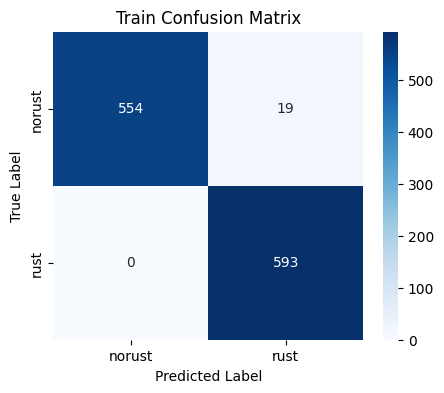

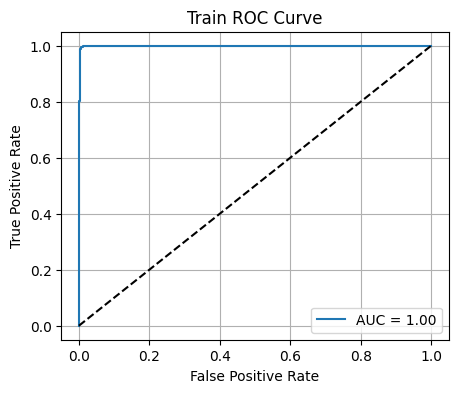


--- Test Set Metrics ---
Accuracy : 0.9760
Precision: 0.9551
Recall   : 1.0000
F1 Score : 0.9770
ROC AUC  : 0.9874

Classification Report:
              precision    recall  f1-score   support

      norust       1.00      0.95      0.97       164
        rust       0.96      1.00      0.98       170

    accuracy                           0.98       334
   macro avg       0.98      0.98      0.98       334
weighted avg       0.98      0.98      0.98       334



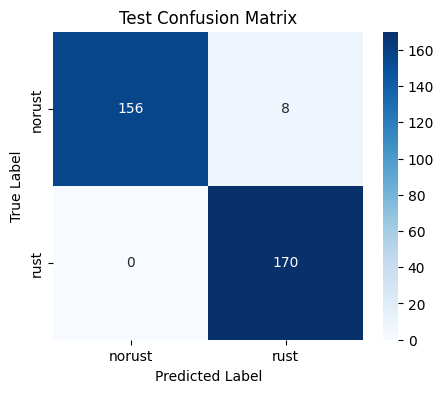

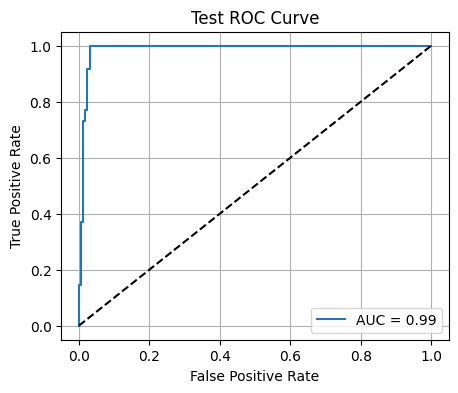

In [39]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model,
                   X_rgb, X_red, X_green, X_blue, X_rededge, X_nir, X_ndvi,
                   y_true, set_name="Set"):
    # Predict probabilities
    y_pred_prob = model.predict(
        [X_rgb, X_red, X_green, X_blue, X_rededge, X_nir, X_ndvi],
        verbose=0
    )

    # If y_true is one-hot encoded, convert to class index
    if y_true.ndim == 2 and y_true.shape[1] == 2:
        y_true = np.argmax(y_true, axis=1)

    y_pred = np.argmax(y_pred_prob, axis=1)

    # Metrics
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob[:, 1])

    # Print metrics
    print(f"\n--- {set_name} Set Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["norust", "rust"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["norust", "rust"],
                yticklabels=["norust", "rust"])
    plt.title(f"{set_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{set_name} ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()


# ✅ Example usage:
evaluate_model(model,
               Xrgb_train, Xred_train, Xgreen_train, Xblue_train,
               Xrededge_train, Xnir_train, Xndvi_train, y_train,
               set_name="Train")

evaluate_model(model,
               Xrgb_test, Xred_test, Xgreen_test, Xblue_test,
               Xrededge_test, Xnir_test, Xndvi_test, y_test,
               set_name="Test")